In [49]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import optimize
import subprocess
%matplotlib inline

In [2]:
scale = 16
i = 1

z_all = []

files = sorted(glob.glob('images/*.jpeg'))
for f in files:
    z = cv2.imread(f)
    
    h, w, _ = z.shape
    z = cv2.resize(z, (w // scale, h // scale))
    z_all.append(z)
    
    outfile = 'tmp_%03d.jpeg' % i
    cv2.imwrite(outfile, z)
    
    i += 1

cmd = 'convert -delay 1x1 `seq -f tmp_%%03g.jpeg 1 1 %d` -coalesce -layers OptimizeTransparency autumn.gif' % (i-1)
subprocess.call(cmd, shell=True)
subprocess.call('rm tmp*.jpeg', shell=True)

In [4]:
Z = np.array(z_all).astype('float').mean(0).astype('uint8')

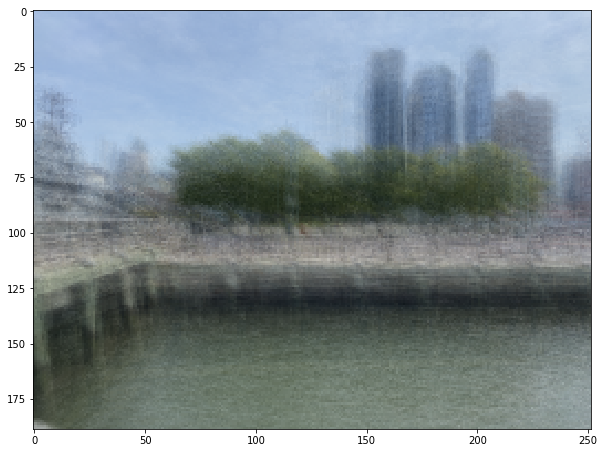

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(Z[:, :, ::-1])
plt.show()

In [44]:
def errfun(x, Z, Zt):
    dx = x[0]
    dy = x[1]
    rot = x[2]
    pad = 25
    
    M = np.array([
        [np.cos(rot), -np.sin(rot), dx],
        [np.sin(rot), np.cos(rot), dy]
    ]).astype('float32')
    
    Zw = cv2.warpAffine(Zt, M, (w // scale, h // scale))
    err = ((Z[pad:-pad, pad:-pad] - Zw[pad:-pad, pad:-pad])**2).sum()
    return err

bounds = optimize.Bounds(
    [-20, -20, -np.pi/6],
    [20, 20, np.pi/6]
)
x0 = np.r_[0, 0, 0]

Z = z_all[-1]
Zt = z_all[-2]
res = optimize.minimize(
    lambda x: errfun(x, Z=Z.astype('float'), Zt=Zt.astype('float')), 
    x0, method='trust-constr', bounds=bounds
)

In [47]:
err = []
for dx in np.linspace(-20, 20, 10):
    for dy in np.linspace(-20, 20, 10):
        for rot in np.linspace(-np.pi/6, np.pi/6, 10):
            e = errfun([dx, dy, rot], Z.astype('float'), Zt.astype('float'))
            err.append({
                'dx': dx,
                'dy': dy,
                'rot': rot,
                'err': e
            })

In [52]:
err = pd.DataFrame(err)

In [55]:
err[err.err==err.err.min()]

,dx,dy,rot,err
535,2.222222,-6.666667,0.058178,2.005588e+08
